In [11]:
import networkx as nx
import os
import ads as ads 
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite as bi

In [12]:
os.environ["ADS_DEV_KEY"] = "kNUoTurJ5TXV9hsw9KQN1k8wH4U0D7Oy0CJoOvyw"

In [13]:
ads.config.token = 'ADS_DEV_KEY'

In [14]:
papers1 = list(ads.SearchQuery(q= "stars", sort="citation_count", max_pages=1 ))

In [15]:
a = []
for i in papers1:
    authors1 = i.author
    a.append(authors1)
author_names = a

In [16]:
j = []
for i in papers1:
    journals1 = i.pub
    j.append(journals1)
journals = j

C:\Users\JGARCIA\Anaconda3\lib\site-packages\ads\utils.py:31: UserWarning: You are lazy loading attributes via 'pub', and so are making multiple calls to the API. This will impact your overall rate limits.
  UserWarning,


In [17]:
df = pd.DataFrame({'Author_Names' : author_names,
 'Journal':journals
  })

In [18]:
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)
s1.name = 'Author_Name'
df_m = df.drop('Author_Names', axis=1).join(s1)
df_m.head()

,Journal,Author_Name
0,Nature Materials,"Geim, A. K."
0,Nature Materials,"Novoselov, K. S."
1,Astronomy and Astrophysics,"Shakura, N. I."
1,Astronomy and Astrophysics,"Sunyaev, R. A."
2,The Astrophysical Journal Supplement Series,"Spergel, D. N."


In [19]:
author_nodes = pd.DataFrame(df_m.Author_Name.unique(),columns=['Author_Name'])
author_nodes['node_type'] = 'Author_Name'
journal_nodes = pd.DataFrame(df_m.Journal.unique(), columns=['Journal'])
journal_nodes['node_type'] = 'Journal'

In [20]:
a_nodes = list(author_nodes['Author_Name'])
j_nodes = list(journal_nodes['Journal'])
edge_bunch = [tuple(i) for i in df_m.values]

g = nx.Graph()
g.add_nodes_from(a_nodes,node_type='Author_Name', bipartite=0)
g.add_nodes_from(j_nodes,node_type='Jurnal', bipartite=1)
g.add_edges_from(edge_bunch)

In [21]:
big_subg = [i for i in nx.connected_component_subgraphs(g) if len(i) > 200]
sg_largest = big_subg[0] 

In [22]:
Journals,Author_Names = bi.sets(sg_largest)

In [23]:
j_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Journals)

In [24]:
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

In [25]:
j = j_proj_sg_largest.edges(data=True) 
a = a_proj_sg_largest.edges(data=True)

In [32]:
print (len([i for i in a if i[2]['weight'] > 1]))
print (len([i for i in j if i[2]['weight'] > 1]))

4
120


In [33]:
def tidy(g, weight):
    g_temp = nx.Graph()
    edge_bunch2 = [i for i in g.edges(data=True) if i[2]['weight'] > weight]    
    g_temp.add_edges_from(edge_bunch2)
    return g_temp

In [34]:
a_sg_island =  tidy(a_proj_sg_largest, 1)
j_sg_island = tidy(j_proj_sg_largest,1)

In [42]:
a_degree = nx.degree_centrality(a_sg_island)
j_degree = nx.degree_centrality(j_sg_island)
pd.DataFrame.from_dict(a_degree,orient='index').sort_values(0,ascending=False).head()

,0
The Astrophysical Journal,1.000000
The Astrophysical Journal Supplement Series,0.666667
Monthly Notices of the Royal Astronomical Society,0.666667
The Astronomical Journal,0.333333


In [43]:
pd.DataFrame.from_dict(j_degree,orient='index').sort_values(0,ascending=False).head()

,0
"Heckman, Timothy M.",0.56
"Brinchmann, Jarle",0.56
"Fukugita, Masataka",0.56
"White, Simon D. M.",0.56
"Tremaine, Scott",0.40


In [44]:
j_connected = [i for i in nx.connected_component_subgraphs(j_proj_sg_largest) if len(i) > 1]
a_connected = [i for i in nx.connected_component_subgraphs(a_proj_sg_largest) if len(i) > 1]

In [45]:
def merge_graph(connected_g):
    g = nx.Graph()
    for h in connected_g:
        g = nx.compose(g,h)
    return g

a_islands = merge_graph(a_connected)
j_islands = merge_graph(j_connected)

AttributeError: module 'matplotlib.pyplot' has no attribute 'ishold'

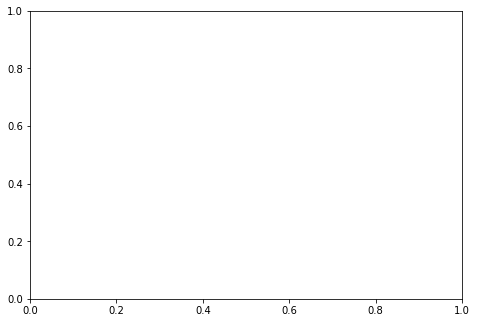

In [46]:
nx.draw(a_islands)

AttributeError: module 'matplotlib.pyplot' has no attribute 'ishold'

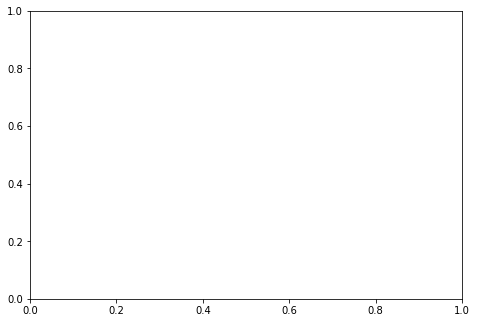

In [47]:
nx.draw(j_islands)
pos=nx.circular_layout(j_islands)